# Basic Data Manipulation

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
# Importing the training data
train = pd.read_csv('data/train.csv', parse_dates=['first_day_of_month'])
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 122265 non-null  object        
 1   cfips                  122265 non-null  int64         
 2   county                 122265 non-null  object        
 3   state                  122265 non-null  object        
 4   first_day_of_month     122265 non-null  datetime64[ns]
 5   microbusiness_density  122265 non-null  float64       
 6   active                 122265 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.5+ MB


In [62]:
# Removing row_id, county, and state because those are redundant columns
train.drop(['row_id', 'county', 'state'], axis=1, inplace=True)

In [63]:
train.head()

,cfips,first_day_of_month,microbusiness_density,active
0,1001,2019-08-01,3.007682,1249
1,1001,2019-09-01,2.884870,1198
2,1001,2019-10-01,3.055843,1269
3,1001,2019-11-01,2.993233,1243
4,1001,2019-12-01,2.993233,1243


In [64]:
# Separating day, month, and year into their own features
train['year'] = train['first_day_of_month'].dt.year
train['month'] = train['first_day_of_month'].dt.month
train['day'] = train['first_day_of_month'].dt.day
train.drop('first_day_of_month', axis=1, inplace=True)

In [65]:
train.head()

,cfips,microbusiness_density,active,year,month,day
0,1001,3.007682,1249,2019,8,1
1,1001,2.884870,1198,2019,9,1
2,1001,3.055843,1269,2019,10,1
3,1001,2.993233,1243,2019,11,1
4,1001,2.993233,1243,2019,12,1


In [66]:
np.unique(train['day'])

array([1], dtype=int64)

In [67]:
# Since the day column has only one value, we can remove that as well
train.drop('day', axis=1, inplace=True)

In [68]:
# Dropping the active column because that's not in the test dataset
train.drop('active', axis=1, inplace=True)

In [69]:
from sklearn.model_selection import train_test_split

X = train.drop(['microbusiness_density'], axis=1)
y = train['microbusiness_density']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# Training

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [71]:
# This will make training/evaluating much simpler
model_dict = {'LinearRegression': LinearRegression(), 
              'RandomForestRegressor': RandomForestRegressor(), 
              'XGBoostRegressor': xgb.XGBRegressor()}

In [72]:
def training(model_dict, X_train, y_train):
  '''
  Trains all the models in `model_dict` on `X_train` and `y_train` and returns
  a dictionary of trained models and the model's names.
  '''
  
  # Training models and documenting when they're training
  for model_name, model in model_dict.items():
    print(f'Training {model_name}...')
    model.fit(X_train, y_train)
  
  return model_dict

In [73]:
trained_model_dict = training(model_dict, X_train, y_train)

Training LinearRegression...
Training RandomForestRegressor...
Training XGBoostRegressor...


In [74]:
trained_model_dict

{'LinearRegression': LinearRegression(),
 'RandomForestRegressor': RandomForestRegressor(),
 'XGBoostRegressor': XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)}

# Evaluation for Basic Models

$$SMAPE = \frac{1}{n} * \sum^{n}_{i=1}{\frac{2 * |P_i - A_i|}{(|A_i| + |P_i|)}}$$ 
where $P$ = predicted value and $A$ = actual value


In [75]:
def SMAPE(actual, pred):
  '''
  Calculates and returns the SMAPE (Symmetrics Mean Absolute Percentage Error) evaluation 
  metric based on the actual values (`actual`) and predicted values (`pred`).
  '''
  
  numerator = np.abs(pred - actual) * 2
  denominator = np.abs(actual) + np.abs(pred)
  return np.mean(numerator / denominator)

In [76]:
def set_axis_color(ax, color):
  '''
  Changes the axes and x and y labels of a graph to `color` for the given plot `ax`
  '''
  
  ax.xaxis.label.set_color(color)
  ax.yaxis.label.set_color(color)
  ax.tick_params(axis='x', colors=color)
  ax.tick_params(axis='y', colors=color)

In [77]:
import random
import colorsys

def model_evaluation(trained_model_dict, X_val, y_val, plot_datapoints):
  '''
  Finds the SMAPE evaluation metric for each model in `trained_model_dict` using
  `X_val` and `y_val`.
  
  Plots the different SMAPE evaluation metrics for each model in `trained_model_dict`.
  
  Plots the prediction values for each model, comparing them to `y_val` (actual values).
  '''
  
  # Getting SMAPE scores & model predictions
  smape_scores = []
  model_preds = []
  for model_name, trained_model in trained_model_dict.items():
    # Calculating validation SMAPE metric
    preds = trained_model.predict(X_val)
    val_smape = SMAPE(y_val, preds)
    
    # Calculating train SMAPE metric
    train_preds = trained_model.predict(X_train)
    train_smape = SMAPE(y_train, train_preds)
    
    # Calculating validation r^2
    val_r2 = trained_model.score(X_val, y_val)
    
    # Calculating train r^2
    train_r2 = trained_model.score(X_train, y_train)
    
    # Appending validation SMAPE and predictions to plot later on
    model_preds.append(preds)
    smape_scores.append(val_smape)
    
    # Documenting Metrics
    print(f'{model_name} (Validation SMAPE): {val_smape * 100:.2f}%')
    print(f'{model_name} (Validation R^2): {val_r2 * 100:.2f}%')
    print(f'{model_name} (Training SMAPE): {train_smape * 100:.2f}%')
    print(f'{model_name} (Training R^2): {train_r2 * 100:.2f}%')
    print('--------------------------------------------------------')
    
  # Plot color-scheme
  colors_scheme = ['orange', 'green', 'red', 'pink']
  
  # Plotting Barplot
  fig1, ax1 = plt.subplots(1, 2, figsize=(20, 7))
  ax1[0].bar(trained_model_dict.keys(), smape_scores, color=colors_scheme)
  
  # Plotting main Lineplot
  ax1[1].plot(np.arange(0, plot_datapoints), y_val[:plot_datapoints], label='Actual Values')
  
  for i in range(len(model_preds)):
    ax1[1].plot(np.arange(0, plot_datapoints), 
               model_preds[i][:plot_datapoints], 
               label=f'{list(trained_model_dict.keys())[i]} Predictions',
               color=colors_scheme[i]) 
      
  # Plotting supportive Lineplots
  fig2, ax2 = plt.subplots(1, len(trained_model_dict), figsize=(20, 4))
  
  for i in range(len(model_preds)):
    ax2[i].plot(np.arange(0, plot_datapoints), 
                y_val[:plot_datapoints], 
                label='Actual Values')
    ax2[i].plot(np.arange(0, plot_datapoints),
                model_preds[i][:plot_datapoints],
                label=f'{list(trained_model_dict.keys())[i]} Predictions', 
                color=colors_scheme[i])
  
  # Main Plot Customizations  
  ax1[1].legend()
  
  ax1[0].set_ylabel('SMAPE (%)')
  set_axis_color(ax1[0], 'white')
  
  ax1[1].set_ylabel('Microbusiness Density')
  ax1[1].set_xlabel('Row Number in Training Set')
  set_axis_color(ax1[1], 'white')
  
  # Supporting Plot Customizations
  ax2[0].set_ylabel('Microbusiness Density')
  for i in range(len(trained_model_dict)):
    ax2[i].set_xlabel('Row Number in Training Set')
    set_axis_color(ax2[i], 'white')
    ax2[i].legend()
  
  plt.show()

LinearRegression (Validation SMAPE): 62.33%
LinearRegression (Validation R^2): 0.04%
LinearRegression (Training SMAPE): 62.29%
LinearRegression (Training R^2): 0.05%
--------------------------------------------------------
RandomForestRegressor (Validation SMAPE): 2.29%
RandomForestRegressor (Validation R^2): 97.71%
RandomForestRegressor (Training SMAPE): 0.89%
RandomForestRegressor (Training R^2): 98.33%
--------------------------------------------------------
XGBoostRegressor (Validation SMAPE): 36.89%
XGBoostRegressor (Validation R^2): 82.99%
XGBoostRegressor (Training SMAPE): 36.55%
XGBoostRegressor (Training R^2): 84.66%
--------------------------------------------------------


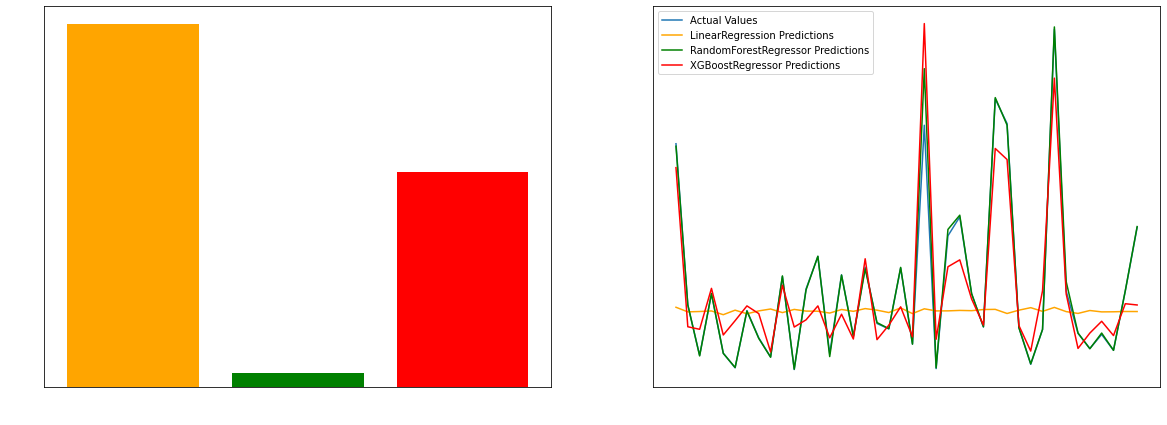

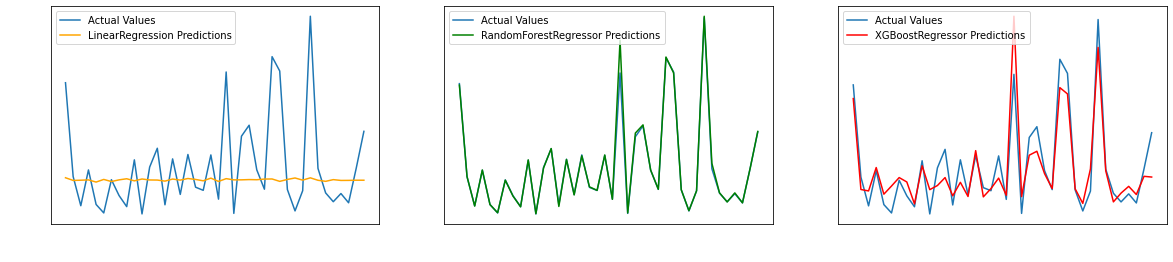

In [78]:
model_evaluation(trained_model_dict, X_val, y_val, 40)

# Feature Importance

In [79]:
feature_importance = trained_model_dict['RandomForestRegressor'].feature_importances_
feature_importance

array([0.79224528, 0.14642635, 0.06132837])

In [80]:
list(X.columns)

['cfips', 'year', 'month']

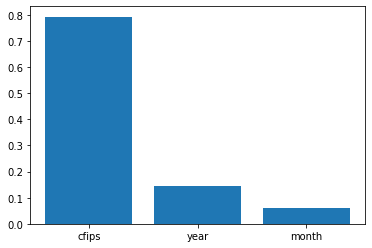

In [81]:
plt.bar(np.array(X.columns), feature_importance);

# First Submission

In [134]:
test = pd.read_csv('data/test.csv', parse_dates=['first_day_of_month'])
test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


### Data Manipulation on Test Set

Need to separate the month and year like we did for the training set... and then we can gather predictions on the test set

In [135]:
X.head()

,cfips,year,month
0,1001,2019,8
1,1001,2019,9
2,1001,2019,10
3,1001,2019,11
4,1001,2019,12


In [140]:
# Saving the test row_id column before dropping it
row_id = test['row_id']

In [141]:
test['year'] = test['first_day_of_month'].dt.year
test['month'] = test['first_day_of_month'].dt.month

# Removing row_id and first_day_of_month column
test.drop(['row_id'], axis=1, inplace=True)
test.drop(['first_day_of_month'], axis=1, inplace=True)

In [142]:
test.head()

,cfips,year,month
0,1001,2022,11
1,1003,2022,11
2,1005,2022,11
3,1007,2022,11
4,1009,2022,11


### Getting Predictions on Test Set

In [143]:
rf_reg = trained_model_dict['RandomForestRegressor']
submission_preds = rf_reg.predict(test)

In [146]:
len(submission_preds), len(row_id)

(25080, 25080)

### Making Submission DataFrame

In [147]:
submission = pd.DataFrame({'row_id': row_id, 
              'microbusiness_density': submission_preds})
submission.head()

,row_id,microbusiness_density
0,1001_2022-11-01,3.430864
1,1003_2022-11-01,8.317137
2,1005_2022-11-01,1.199628
3,1007_2022-11-01,1.275655
4,1009_2022-11-01,1.831061


In [150]:
submission.to_csv('data/first_basic_submission.csv', index=False)

# Future Steps

* It is to be noted that Random Forest is doing quite well on the data
* Need to combine census data and the training set
* May want to use models like SARIMA and ARIMA which are good for forecast modeling
* Above, we removed the `active` column from the training set but it helped the model a lot when we trained on it, so try to get that data for test set
* Need to combine loads of data found <a href='https://www.godaddy.com/ventureforward/microbusiness-datahub/'>here</a> with training set